In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import string
import random
from collections import defaultdict
import statistics

import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

np.random.seed(7)

Dataset mozete preuzeti sa https://www.kaggle.com/datasets/aadhavvignesh/captcha-images

In [2]:
captchas=os.listdir('dataset')
names=[name.split('.')[0] for name in captchas]

n=len(captchas)
print("Broj slika: ",n)

img_shape=cv2.imread("dataset/"+captchas[0]).shape
print("Dimenzije slika: ",img_shape)

Broj slika:  10000
Dimenzije slika:  (90, 282, 3)


Simboli koji se mogu pojaviti su mala i velika slova kao i cifre

In [4]:
symbols=string.ascii_lowercase+string.ascii_uppercase+string.digits
num_symbols=len(symbols)
print("Moguci simboli: ",symbols)
print("Broj mogucih simbola: ",num_symbols)

Moguci simboli:  abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789
Broj mogucih simbola:  62


In [6]:
#provera da stvarno nase slike ne sadrze dodatne simbole
characters = set(char for label in names for char in label)
print(''.join(characters),len(characters))

zZtoh8wKY39aNdgsIjOr7AuCbLT0lc2BRqQiDVeyXEJvxmf1nUG5Hk6FpSWP4M 62


Primer nekih slika, prikazacemo prve dve samo

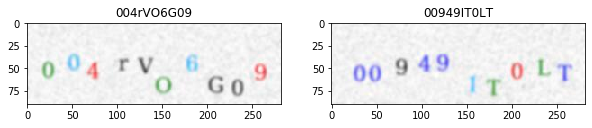

In [7]:
first=cv2.imread('dataset/'+captchas[0])
second=cv2.imread('dataset/'+captchas[1])
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.title(names[0])
plt.imshow(first)
plt.subplot(1,2,2)
plt.title(names[1])
plt.imshow(second)

In [8]:
#pomocna funkcija za promenu dimenzije slicica
def promena_dimenzija(img_list,trening=True,interpolation=cv2.INTER_CUBIC):
    im_list_resize=[cv2.resize(img,(int(v),int(h)),interpolation=interpolation) for img in img_list]
    
    return im_list_resize

Naredna funkcija nam omogucava da obradimo nase slike, prepoznamo i izdvojimo delove-simbole. Izdvojeni delovi i labele se cuvaju u pomocnim strukturama- slike i vrednosti. 
O tome kako smo dosli do ove obrade mozete vise pogledati u dodatku.
Funkcija ima argumente: 
-prikaz-kada je True ne vrsi se filtriranje neispravnih delova i samo se prikazuju izdvojeni
-save-kad je True cuvamo izdvojene simbole zajedno sa informacijom iz koje slike je izvucen deo
-samo-kada je True samo se vrsi obrada-koristimo kada zelimo da preprocesiramo test primere

In [11]:
#obrada slike i izdvajanje delova
#moguce je i prikazati izdvojene delove i sacuvati ih
def obrada(j,prikaz=False,save=False,samo=False):
    first=cv2.imread('dataset/'+ captchas[j])
    hs,ws=first.shape[:2]
    P=hs*ws
    
    proc1_first=cv2.cvtColor(first,cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(proc1_first, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel = np.ones((3,3),np.uint8)
    thresh= cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts = sorted(cnts, key=lambda x: cv2.boundingRect(x)[0])

    eps=1
    number = 0
    xp=0
    wp=0
    pp=0
    xmax=0
    xpp=[]
    xpk=[]
    ypp=[]
    delova=0
    if prikaz:
        plt.figure(figsize=(20,50))
    i=1
    
    imgs=dict([])
    imgsamo=defaultdict(list)
    
    for c in cnts:
        area = cv2.contourArea(c)
        x,y,w,h = cv2.boundingRect(c)
        if (x+w)>xmax:
            xmax=x+w
        if x>=xp and ((x+w)<=(xp+wp) or xmax>(x+w)):
            xp=x
            wp=w
            continue
        elif area<P/30 and area>P/500:
            if(i>10 and not samo):
                return -1
            if pp>P/700:
                number += 1
                n=len(xpp)
                
                ROI =thresh[max(min(ypp)-eps,0):min(max(ypp)+eps,hs),max(min(xpp)-eps,0):min(max(xpk),ws)]
                imgs[names[j][i-1]+str(i)]=ROI
                if samo:
                    imgsamo[0].append(ROI)
                if prikaz:
                    plt.subplot(1,10,i)
                    plt.title(names[j][i-1])
                    plt.imshow(ROI,cmap='gray')
                i=i+1
            if(i>10 and not samo):
                return -1
            pp=0
            xpp=[]
            xpk=[]
            ypp=[]
            ROI=thresh[max([y-eps,0]):min([y+h+eps,hs]),max([x-eps,0]):min([x+w,ws])]
            ROI =thresh[y:y+h, x:x+w]
            
            imgs[names[j][i-1]+str(i)]=ROI
            if samo:
                imgsamo[0].append(ROI)
            
            if prikaz:
                plt.subplot(1,10,i)
                plt.title(names[j][i-1])
                plt.imshow(ROI,cmap='gray')
                
            i=i+1
            number += 1
            xp=x
            wp=w
        else:
            if(i>10 and not samo):
                return -1
            if pp>P/700:
                number += 1
                n=len(xpp)
                
                ROI =thresh[max(min(ypp)-eps,0):min(max(ypp)+eps,hs),max(min(xpp)-eps,0):min(max(xpk),ws)]
                imgs[names[j][i-1]+str(i)]=ROI
                if samo:
                    imgsamo[0].append(ROI)
                    
                if prikaz:
                    plt.subplot(1,10,i)
                    plt.title(names[j][i-1])
                    plt.imshow(ROI,cmap='gray')
                i=i+1
                pp=0
                xpp=[]
                xpk=[]
                ypp=[]
            if(area<5):
                continue
            pp=pp+area
            delova=delova+1
            xpp=xpp+[x]
            xpk=xpk+[x+w]
            ypp=ypp+[y]+[y+h]
            
    
    if pp>P/700:
        if(i>10 and not samo):
            return -1
        number += 1
        n=len(xpp)
        ROI =thresh[max(min(ypp)-eps,0):min(max(ypp)+eps,hs),max(min(xpp)-eps,0):min(max(xpk),ws)]
        imgs[names[j][i-1]+str(i)]=ROI
        if samo:
            imgsamo.append(ROI)
            
        if prikaz:
            plt.subplot(1,10,i)
            plt.title(names[j][i-1])
            plt.imshow(ROI,cmap='gray')
        i=i+1
        pp=0
        xpp=[]
        xpk=[]
        ypp=[]
    
    if samo:
        return imgsamo

    if(number==10 and not prikaz):
        for (kljuc, vrednost) in imgs.items():
            prop=len(vrednost[vrednost==255])/(len(vrednost)*len(vrednost[0]))
            if prop>0.85 or prop<0.1:
                continue
            
            if save:
                cv2.imwrite('v2/{}.png'.format(kljuc+names[j]), vrednost)
            
            slike[0].append(vrednost)
            
            ypom=np.zeros(len(symbols))
            ypom[symbols.find(kljuc[0])]=1
            vrednosti[0].append(ypom)

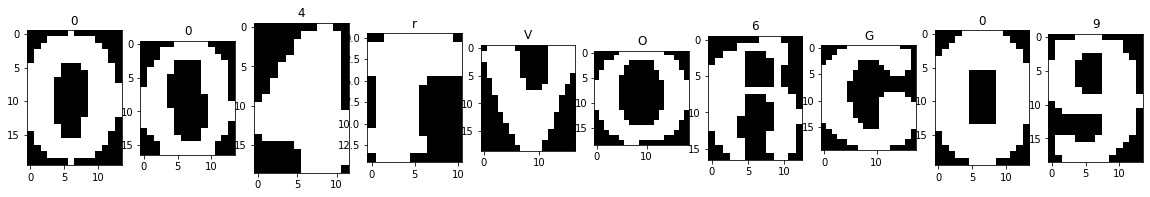

In [12]:
#primer obrade-vidimo da su slike razlicitih dimenzija
#prikaz je True pa nam obrada sluzi samo za izdvajanje delova-bez filtriranja i cuvanja u strukturama podataka
obrada(0,prikaz=True)

Sada cemo obraditi sve slike. Izdvojicemo ispravne simbole i enkodirani simbol koji predstavljaju. Rezultate cuvamo u vrednosti i slike

In [13]:
slike = defaultdict(list)
vrednosti=defaultdict(list)

for i in range(len(captchas)):
    obrada(i)

Svodimo sve slike na istu dimenziju 

Prosecne dimenzije izdvojenih slika:  18.539528139443554 13.571896806935927


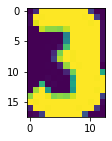

In [14]:
img_list=slike[0]
h=statistics.mean([img.shape[0] for img in img_list])
v=statistics.mean([img.shape[1] for img in img_list])
print("Prosecne dimenzije izdvojenih slika: ",h,v)

Xall=promena_dimenzija(img_list)

#primer jednog izdvojenog simbola
plt.figure(figsize=(2,2))
plt.imshow(Xall[900])

In [15]:
yall=vrednosti[0] #sve ciljne promenljive
print(yall[900]) #ispisujemo za ovu nas test sliku

def get_symbol(index):
    return symbols[np.argmax(yall[index])]

print("Vrednost simbola je:", get_symbol(900))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Vrednost simbola je: 3


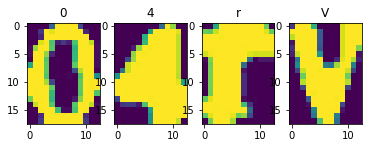

In [16]:
#jos neki primeri izdvojenih simbola
plt.figure(figsize=(6,5))
for i in range(1,5):
    plt.subplot(1,4,i)
    plt.title(get_symbol(i)) #prikaza radi
    plt.imshow(Xall[i])

In [17]:
#Sada su nase slike dimenzija:
imgh,imgv=Xall[0].shape
input_shape=(imgh,imgv,1)
print("Dimenzije: ",imgh,"x",imgv)

number_of_classes=len(symbols)

y=np.array(yall)
X=np.array([x.reshape(imgh,imgv,1) for x in Xall])

Dimenzije:  18 x 13


Podela na skupove za trening,test i validaciju

In [18]:
X_train_validation, X_test, y_train_validation, y_test =train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)
X_train, X_validation, y_train, y_validation =train_test_split(X_train_validation, y_train_validation, test_size=0.2, random_state=7, stratify=y_train_validation)

X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.astype('float32')
X_test /= 255
X_validation=X_validation.astype('float32')
X_validation /= 255

# Kreiranje modela

O tome kako smo izabrali parametre modela pogledajte u dodatku. Sada cemo prvo prikazati rezultate na pocetnom modelu.

In [20]:
model = Sequential([
        Input(shape=input_shape),
        Conv2D(filters=30, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
        Conv2D(filters=60, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.3),
        Dense(number_of_classes, activation='softmax')
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 13, 30)        300       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 13, 60)        16260     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 6, 60)          0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 6, 60)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3240)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               324100    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0

In [21]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
batch_size = 100
epochs = 15

#Treniramo model
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_validation,y_validation)
                   )

score = model.evaluate(X_test, y_test)

Epoch 1/15
424/424 [==============================] - 28s 65ms/step - loss: 0.7467 - accuracy: 0.8108 - val_loss: 0.1893 - val_accuracy: 0.9540
Epoch 2/15
424/424 [==============================] - 30s 71ms/step - loss: 0.2270 - accuracy: 0.9421 - val_loss: 0.1495 - val_accuracy: 0.9635
Epoch 3/15
424/424 [==============================] - 34s 80ms/step - loss: 0.1808 - accuracy: 0.9553 - val_loss: 0.1412 - val_accuracy: 0.9649
Epoch 4/15
424/424 [==============================] - 36s 85ms/step - loss: 0.1571 - accuracy: 0.9605 - val_loss: 0.1281 - val_accuracy: 0.9714
Epoch 5/15
424/424 [==============================] - 31s 74ms/step - loss: 0.1452 - accuracy: 0.9626 - val_loss: 0.1229 - val_accuracy: 0.9739
Epoch 6/15
424/424 [==============================] - 30s 71ms/step - loss: 0.1275 - accuracy: 0.9681 - val_loss: 0.1167 - val_accuracy: 0.9760
Epoch 7/15
424/424 [==============================] - 30s 72ms/step - loss: 0.1179 - accuracy: 0.9705 - val_loss: 0.1136 - val_accuracy:

In [22]:
print(model.metrics_names)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

['loss', 'accuracy']
Test loss: 0.13614434003829956
Test accuracy: 0.9796858429908752


Cine se uredu i acc i loss, ali pogledajmo loss na trening skupu i na validacionom skupu.

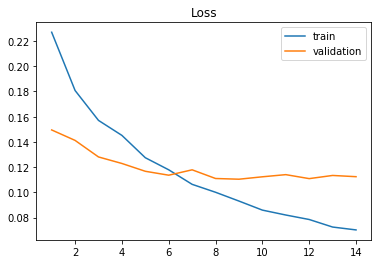

In [23]:
plt.title('Loss')
plt.plot(np.arange(1, epochs), history.history['loss'][1:], label='train')
plt.plot(np.arange(1, epochs), history.history['val_loss'][1:], label='validation')
plt.legend(loc='best')

Mogli bismo se zaustaviti posle 6 epohe ali to ne resava nas problem.
Pogledajmo raspodelu simbola nad kojim treniramo

<BarContainer object of 62 artists>

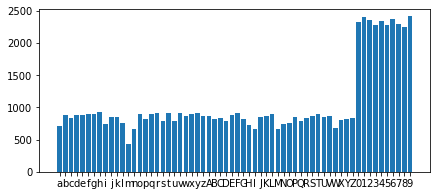

In [25]:
pojavljivanja=np.bincount([np.argmax(yi) for yi in y])
plt.figure(figsize=(7,3))
plt.bar([c for c in symbols],pojavljivanja)

Pre kreiranja novog modela sacuvacemo stari model

In [27]:
from tensorflow.keras.models import load_model
model_path = 'badcaptcha_model.h5'
model.save(model_path)

Vidimo da nas skup podataka ima vise informacija o ciframa nego o slovima, tj nas skup podataka je nebalansiran.
Kreiracemo model sa tezinama. Posto nase promenljive su enkodirane nije jednostavno da izracunamo tezine nekom ugradjenom funkcijom pa cemo rucno izracunati.

In [26]:
train_size=y_train.shape[0]
pojavljivanja_train=np.bincount([np.argmax(yi) for yi in y_train])
weights=train_size/(num_symbols*pojavljivanja_train)
print(weights)
class_weights = dict(enumerate(weights))

[1.51530649 1.20956323 1.28218241 1.20956323 1.20956323 1.18031645
 1.19685329 1.15635064 1.43874363 1.26322223 1.26556153 1.40907882
 2.44072581 1.60423292 1.19685329 1.29432429 1.19059795 1.16621711
 1.35595878 1.16423037 1.34793536 1.17423235 1.23581053 1.18646393
 1.17423235 1.24255132 1.23135716 1.30669833 1.27500602 1.34793536
 1.21386008 1.16821064 1.29924568 1.47922776 1.61561046 1.25395087
 1.23357983 1.19059795 1.61561046 1.42672907 1.40907882 1.24936604
 1.34528194 1.27978132 1.22473696 1.19267579 1.25856948 1.23135716
 1.56028134 1.31423697 1.29432429 1.28701172 0.45743188 0.4446345
 0.45439044 0.4690482  0.45621043 0.46776401 0.44901657 0.46458411
 0.47392734 0.44290553]


Novi model sa tezinama, morali smo da izmenimo strukturu nase mreze kako bismo se prilagodili novonastaloj situaciji.
Detaljnije u dodatku.

In [28]:
model = Sequential([
        Input(shape=input_shape),
        Conv2D(filters=30, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
        Conv2D(filters=60, kernel_size=3, strides=(1, 1), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(70, activation='relu'),
        Dropout(0.3),
        Dense(number_of_classes, activation='softmax')
    ])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 18, 13, 30)        300       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 13, 60)        16260     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 6, 60)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3240)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               324100    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 70)               

In [29]:
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
batch_size = 100
epochs = 15

#model je sa tezinama sada
history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_validation,y_validation),
                    class_weight=class_weights
                   )
score = model.evaluate(X_test, y_test)

Epoch 1/15
424/424 [==============================] - 25s 57ms/step - loss: 1.2755 - accuracy: 0.6598 - val_loss: 0.2271 - val_accuracy: 0.9385
Epoch 2/15
424/424 [==============================] - 24s 57ms/step - loss: 0.3926 - accuracy: 0.8928 - val_loss: 0.1812 - val_accuracy: 0.9520
Epoch 3/15
424/424 [==============================] - 28s 67ms/step - loss: 0.3052 - accuracy: 0.9179 - val_loss: 0.1815 - val_accuracy: 0.9500
Epoch 4/15
424/424 [==============================] - 35s 83ms/step - loss: 0.2583 - accuracy: 0.9288 - val_loss: 0.1593 - val_accuracy: 0.9649
Epoch 5/15
424/424 [==============================] - 35s 82ms/step - loss: 0.2264 - accuracy: 0.9387 - val_loss: 0.1502 - val_accuracy: 0.9677
Epoch 6/15
424/424 [==============================] - 29s 69ms/step - loss: 0.2090 - accuracy: 0.9456 - val_loss: 0.1422 - val_accuracy: 0.9688
Epoch 7/15
424/424 [==============================] - 28s 66ms/step - loss: 0.1922 - accuracy: 0.9507 - val_loss: 0.1446 - val_accuracy:

In [30]:
print(model.metrics_names)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

['loss', 'accuracy']
Test loss: 0.1488058716058731
Test accuracy: 0.9777224063873291


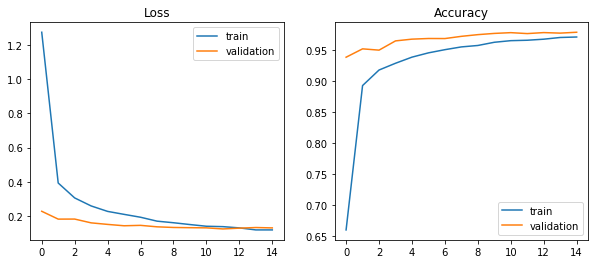

In [31]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(np.arange(0, epochs), history.history['loss'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_loss'], label='validation')
plt.legend(loc='best')


plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(np.arange(0, epochs), history.history['accuracy'], label='train')
plt.plot(np.arange(0, epochs), history.history['val_accuracy'], label='validation')
plt.legend(loc='best')

plt.show()

In [32]:
y_predicted=model.predict(X_test)

cm= confusion_matrix([symbols[np.argmax(y)] for y in y_test],[symbols[np.argmax(y)] for y in y_predicted])
print(cm)

[[457   0   0 ...   0   0   0]
 [  0 446   0 ...   0   0   0]
 [  0   1 458 ...   0   0   1]
 ...
 [  0   0   0 ... 178   0   1]
 [  0   0   0 ...   0 179   0]
 [  0   0   0 ...   0   0 172]]


In [33]:
report = classification_report([symbols[np.argmax(y)] for y in y_test],[symbols[np.argmax(y)] for y in y_predicted])
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       467
           1       0.97      0.93      0.95       481
           2       0.99      0.97      0.98       470
           3       1.00      0.98      0.99       455
           4       0.99      1.00      0.99       468
           5       0.99      0.99      0.99       457
           6       1.00      0.99      0.99       476
           7       1.00      1.00      1.00       460
           8       1.00      0.99      0.99       450
           9       1.00      1.00      1.00       483
           A       1.00      0.99      1.00       174
           B       0.99      0.99      0.99       164
           C       0.89      0.98      0.93       167
           D       0.99      0.96      0.97       158
           E       0.99      0.94      0.97       176
           F       0.96      0.98      0.97       183
           G       0.97      0.90      0.93       165
           H       0.96    

Sacuvajmo model

In [34]:
model_path = 'goodcaptcha_model.h5'
model.save(model_path)

Pogledajmo predvidjanja

2


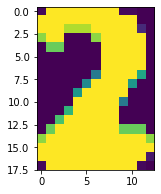

In [35]:
fig = plt.figure(figsize=(3,3))
plt.imshow(X_test[444].reshape(imgh,imgv))
print(symbols[np.argmax(y_predicted[444])])

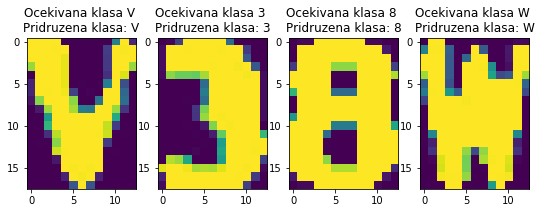

In [36]:
#jos neka predvidjanja 
fig = plt.figure(figsize=(9,4))

for i in range(1,5):
    fig.add_subplot(1,4, i)
    img = X_test[i+50].reshape(imgh,imgv)
    true_label = symbols[np.argmax(y_test[i+50])] #dodajm 50 kako bi simboli bili raznovrsniji
    predicted_label = symbols[np.argmax(y_predicted[i+50])]
    plt.title('Ocekivana klasa {0} \nPridruzena klasa: {1}'.format(true_label, predicted_label))
    plt.imshow(img)

In [37]:
#Naravno imamo i pogresno klasifikovane simbole
predicted_labels = np.argmax(y_predicted, axis=1)
true_labels = np.argmax(y_test, axis=1)
error_indexes = np.where(predicted_labels != true_labels)[0]

number_of_errors = len(error_indexes)
print("Broj gresaka ",number_of_errors)

Broj gresaka  295


Captcha razbijanje- samo cemo isprocesirati sliku a zatim prepoznati simbol po simbol

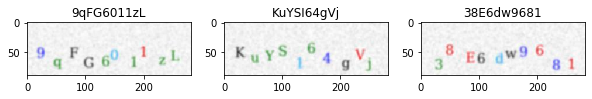

In [47]:
plt.figure(figsize=(10,20))
for i in range(0,3):
    j=np.random.randint(0,n)
    md=obrada(j,samo=True)
    delovi=promena_dimenzija(md[0])
    delovi=np.array([x.reshape(imgh,imgv,1) for x in delovi])
    delovi=delovi/255.0

    predicted=model.predict(delovi)

    stringic=""
    for p in predicted:
        stringic=stringic+symbols[np.argmax(p)]

    plt.subplot(1,3,i+1)
    plt.title(stringic)
    plt.imshow(cv2.imread('dataset/'+captchas[j]))